In [138]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

In [139]:
train_df = pd.read_csv("./jinnan_round1_train_20181227.csv")
test_df = pd.read_csv("./jinnan_round1_testA_20181227.csv")

In [140]:
views = []
for col in train_df.columns:
    views.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96,96.991404,float64
7,A7,75,89,89.326648,object
8,A8,8,89,89.326648,float64
39,B11,37,60,60.816619,object
38,B10,180,17,17.478510,object
3,A3,3,3,95.702006,float64
0,sample id,1396,0,0.071633,object
33,B5,60,0,17.550143,object
26,A26,88,0,18.982808,object
27,A27,13,0,45.128940,int64


In [141]:
views = []
for col in test_df.columns:
    views.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98,98.000000,float64
7,A7,15,88,88.000000,object
8,A8,2,88,88.000000,float64
39,B11,11,59,59.333333,object
38,B10,50,14,14.666667,object
3,A3,2,2,97.333333,float64
0,sample id,150,0,0.666667,object
32,B4,51,0,20.666667,object
26,A26,41,0,21.333333,object
27,A27,11,0,47.333333,float64


In [142]:
for df in [train_df, test_df]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

features = list(train_df.columns)
for col in train_df.columns:
    rate = train_df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.95:
        features.remove(col)
train_df = train_df[features]
features.remove('score')
test_df = test_df[features]

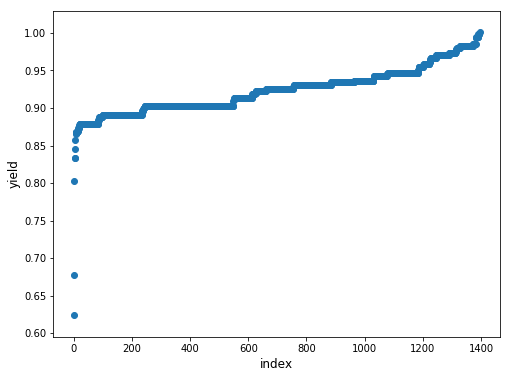

In [143]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

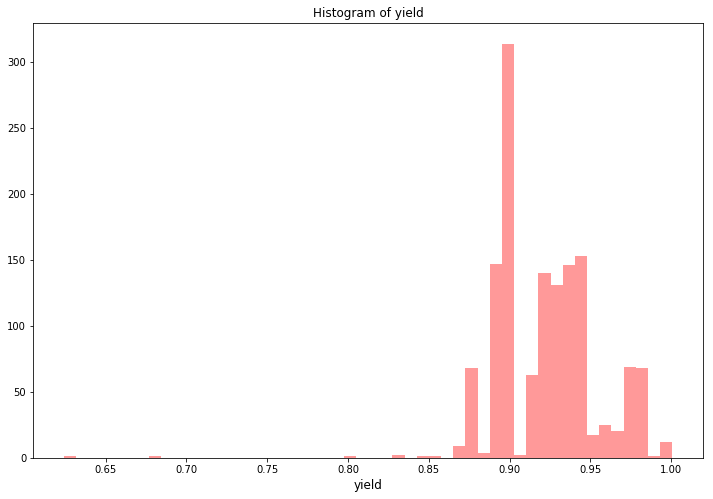

In [144]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [145]:
train_df = train_df[train_df[target_col]>0.87]

In [146]:
def TimeToInt(str, previous = 0):
    now = 0
    try:
        time = str.split(":")
        now = (int(time[0]) * 60 + int(time[1])) * 60
        if now < previous:
            now += 86400
    except:
        now = previous
    return now

def getInt(str):
    val = str.split(":")
    return int(val[0]) * 60 + int(val[1])

def TimeToDuration(str):
    duration = 0
    try:
        time = str.split("-")
        duration = getInt(time[1]) - getInt(time[0])
    except:
        duration = 0
    if duration < 0:
        duration += 24 * 60
    return duration

In [147]:
for df in [train_df, test_df]:
    df['timeA5'] = df['A5'].apply(lambda x: TimeToInt(x))
    df['timeA9'] = df.apply(lambda x: TimeToInt(x.A9, x.timeA5), axis = 1)
    df['timeA11'] = df.apply(lambda x: TimeToInt(x.A11, x.timeA9), axis = 1)
    df['timeA14'] = df.apply(lambda x: TimeToInt(x.A14, x.timeA11), axis = 1)
    df['timeA16'] = df.apply(lambda x: TimeToInt(x.A16, x.timeA14), axis = 1)
    df['timeA24'] = df.apply(lambda x: TimeToInt(x.A24, x.timeA16), axis = 1)
    df['timeA26'] = df.apply(lambda x: TimeToInt(x.A26, x.timeA24), axis = 1)
    df['timeB5'] = df.apply(lambda x: TimeToInt(x.B5, x.timeA26), axis = 1)
    df['timeB7'] = df.apply(lambda x: TimeToInt(x.B7, x.timeB5), axis = 1)
    df['durationA20'] = df['A20'].apply(lambda x: TimeToDuration(x))
    df['durationA28'] = df['A28'].apply(lambda x: TimeToDuration(x))
    df['durationB4'] = df['B4'].apply(lambda x: TimeToDuration(x))
    df['durationB9'] = df['B9'].apply(lambda x: TimeToDuration(x))
    df['durationB10'] = df['B10'].apply(lambda x: TimeToDuration(x))
    df['durationB11'] = df['B11'].apply(lambda x: TimeToDuration(x))
    df = df.drop(['A20', 'A28', 'B4', 'B9', 'B10', 'B11'], axis=1)
    df = df.drop(['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7'], axis=1)

In [148]:
train_df.columns

Index([u'sample id', u'A5', u'A6', u'A7', u'A8', u'A9', u'A10', u'A11', u'A12',
       u'A14', u'A15', u'A16', u'A17', u'A19', u'A20', u'A21', u'A22', u'A24',
       u'A25', u'A26', u'A27', u'A28', u'B1', u'B4', u'B5', u'B6', u'B7',
       u'B8', u'B9', u'B10', u'B11', u'B12', u'B14', u'score', u'timeA5',
       u'timeA9', u'timeA11', u'timeA14', u'timeA16', u'timeA24', u'timeA26',
       u'timeB5', u'timeB7', u'durationA20', u'durationA28', u'durationB4',
       u'durationB9', u'durationB10', u'durationB11'],
      dtype='object')

In [149]:
def toFloat(str):
    try:
        return float(str)
    except:
        return float(0)
train_set = train_df
train_set.loc[train_set['A25'].apply(lambda x: toFloat(x))]
train_set.head()

,sample id,A5,A6,A7,A8,A9,A10,A11,A12,A14,...,timeA24,timeA26,timeB5,timeB7,durationA20,durationA28,durationB4,durationB9,durationB10,durationB11
0,sample_1528,13:30:00,38.0,NaN,NaN,15:30:00,100,16:30:00,102,17:30:00,...,79200,81000,115200,127800,30,30,60,90,90,0
1,sample_1698,14:00:00,29.0,NaN,NaN,16:00:00,101,17:00:00,103,18:00:00,...,72000,75600,82800,108000,60,60,60,90,90,60
2,sample_639,14:00:00,29.0,NaN,NaN,16:00:00,102,17:00:00,103,18:00:00,...,72000,75600,82800,90000,30,60,60,90,90,60
3,sample_483,1:30:00,38.0,NaN,NaN,3:00:00,100,4:00:00,102,5:00:00,...,27000,28800,55800,64800,30,60,60,90,90,0
4,sample_617,22:00:00,29.0,NaN,NaN,0:00:00,101,1:00:00,103,2:00:00,...,100800,104400,111600,118800,60,60,60,90,90,60


In [150]:
target = train_df['score']
del train_df['score']
data = pd.concat([train_df,test_df],axis=0,ignore_index=True)
data = data.fillna(-1)

cate_columns = [f for f in data.columns if f != 'sample id']

#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train_df.shape[0]]
test  = data[train_df.shape[0]:]

In [153]:
# one-hot
X_train = pd.DataFrame()
X_test = pd.DataFrame()
enc = OneHotEncoder(categories='auto')
for f in cate_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')

In [154]:
y_train = target.values

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

# 五折交叉验证
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, 
                    trn_data, 
                    num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)))


fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000303301	valid_1's l2: 0.000287697
[400]	training's l2: 0.000232972	valid_1's l2: 0.000250251
[600]	training's l2: 0.000208603	valid_1's l2: 0.00023928
[800]	training's l2: 0.000195993	valid_1's l2: 0.000235755
[1000]	training's l2: 0.000187109	valid_1's l2: 0.000233167
[1200]	training's l2: 0.000181143	valid_1's l2: 0.000232249
[1400]	training's l2: 0.000177052	valid_1's l2: 0.000231521
[1600]	training's l2: 0.000173699	valid_1's l2: 0.0002311
Early stopping, best iteration is:
[1675]	training's l2: 0.000172388	valid_1's l2: 0.000230578
fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000299534	valid_1's l2: 0.000262794
[400]	training's l2: 0.000226876	valid_1's l2: 0.000227149
[600]	training's l2: 0.000206887	valid_1's l2: 0.000218763
[800]	training's l2: 0.000194825	valid_1's l2: 0.000213857
[1000]	training's l2: 0.000187995	valid_1's l2: 0.00

In [155]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.5f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422766	valid_data-rmse:0.42448
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.257027	valid_data-rmse:0.258239
[200]	train-rmse:0.156778	valid_data-rmse:0.157408
[300]	train-rmse:0.09614	valid_data-rmse:0.096063
[400]	train-rmse:0.059582	valid_data-rmse:0.059178
[500]	train-rmse:0.037719	valid_data-rmse:0.037387
[600]	train-rmse:0.024726	valid_data-rmse:0.025051
[700]	train-rmse:0.017003	valid_data-rmse:0.018732
[800]	train-rmse:0.012456	valid_data-rmse:0.01597
[900]	train-rmse:0.009804	valid_data-rmse:0.015035
[1000]	train-rmse:0.008279	valid_data-rmse:0.014843
[1100]	train-rmse:0.007399	valid_data-rmse:0.014878
[1200]	train-rmse:0.006889	valid_data-rmse:0.014987
Stopping. Best iteration:
[1013]	train-rmse:0.008135	valid_data-rmse:0.014838

fold n°2
[0]	train-rmse:0.423265	valid_data-rmse:0.422498
Multiple eval metrics have been passe

In [156]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.5f}".format(mean_squared_error(target.values, oof_stack)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.00019 


In [157]:
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("submission.csv", index=False, header=None)